In [1]:
'''
Last Run: 6/10/19
Author: Joey Li
Description: The Schur basis transform, described by Bacon, Chuang, and Harrow, is a useful protocol in quantum 
information theory with wide-ranging applications. In the qubit case, it reduces to simple addition of angular
moment. In their paper, BCH give a high-level description of an efficient circuit for the Schur transform. 
This is a small script attempting to explicitly build the circuit for the qubit case.
'''

from qiskit import IBMQ
from qiskit import(QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister)
from qiskit.visualization import plot_histogram
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from numpy import matrix
from math import pi
from math import sqrt


print("Available backends:")
IBMQ.stored_accounts()
IBMQ.load_accounts()
IBMQ.backends()


simulator = Aer.get_backend('qasm_simulator')
backend = IBMQ.get_backend('ibmqx4')

Available backends:


{'0000': 0.55, '0001': 0.0, '0010': 0.08966796875, '0011': 0.0, '0100': 0.075615234375, '0101': 0.0, '0110': 0.12, '0111': 0.0, '1000': 0.0, '1001': 0.0, '1010': 0.0, '1011': 0.09033203125, '1100': 0.0, '1101': 0.074384765625, '1110': 0.0, '1111': 0.0}
Amount of (1,1):
0.55
Amount of (1,0):
0.165283203125
Amount of (1,-1):
0.12
Amount of (0,0):
0.16471679687500002


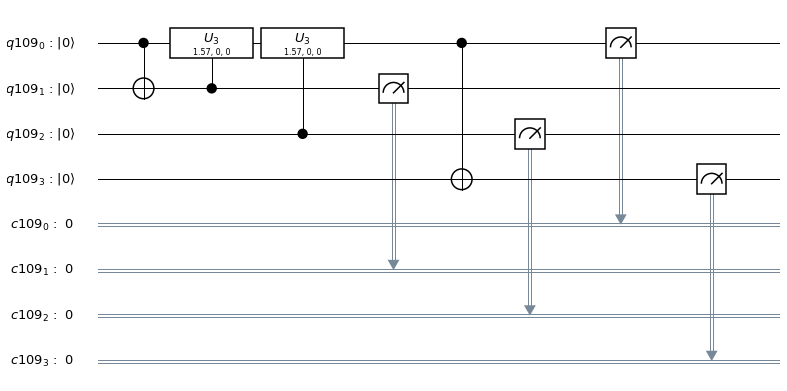

In [4]:
'''
Last Updated: 6/10
Case: n=2 logical qubits

Implementation Details: The top qubit, qubit 3, stores J, representing J=1/2 for initial input 0 and representing 
J=0 with 1 and J=1 with 0
Qubits 2 and 1 store the m value, with qubit 2 initially storing 0 for 1/2 and 1 for -1/2. At measurement, the two 
qubit state 00 represents 1, 01 and 10 both represent 0, and 11 represents 1.
Qubit 0 stores the spin in the normal way, and afterward the value of p.
'''

# Prepare mixed states that are 0 with probability p
def randomize(qc,regs,p):
    for i in regs:
        if random.random() > p:
            qc.x(i)
        
shots = 1024
trials = 100
qubits = 4
cbits = 4
pval = 0.7

# Generates cleanData, which stores all the possible outcomes we should get. 
cleanData = {}
for i in range(2**qubits):
    cleanData[str(bin(i)[2:].zfill(qubits))] = 0


for i in range(trials):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(cbits)
    qc = QuantumCircuit(qr,cr)
    
    # Used to create "mixed states"
    randomize(qc,[0,2],pval)

    
    # Logical controlled-NOT from spin s to momentum m
    qc.cx(qr[0], qr[1])
    # Logical controlled-Y rotation from J,m to s
    qc.cu3(pi/2, 0,0,qr[1],qr[0])
    qc.cu3(pi/2, 0,0,qr[2],qr[0])
    # Logical controlled-NOT from spin s to J
    qc.cx(qr[0],qr[3])


    qc.measure([0,1,2,3],[0,1,2,3])
    qc.draw(output = 'mpl')
    job = execute(qc,simulator, shots=shots)
    result = job.result()
    data = result.get_counts(qc)

    for i in data.keys():
        cleanData[i] += data[i]/shots


for i in cleanData.keys():
    cleanData[i] = cleanData[i]/trials
    
print(cleanData)

print("Amount of (1,1):")
print(cleanData['0000'])
print("Amount of (1,0):")
print(cleanData['0010']+cleanData['0100'])
print("Amount of (1,-1):")
print(cleanData['0110'])
print("Amount of (0,0):")
print(cleanData['1101']+cleanData['1011'])


qc.draw(output = 'mpl')


  

{'01100': 0.03, '01000': 0.074150390625, '11001': 0.08126953125, '11010': 0.064580078125, '00100': 0.152431640625, '10101': 0.157998046875, '10110': 0.1495703125, '00000': 0.29}
Amount of (3/2,3/2):
0.29
Amount of (3/2,1/2):
0.152431640625
Amount of (3/2,-1/2):
0.074150390625
Amount of (3/2,-3/2):
0.03
Amount of normal (1/2,1/2):
0.1495703125
Amount of normal (1/2,-1/2):
0.064580078125
Amount of rotated (1/2,1/2):
0.157998046875
Amoutn of rotated (1/2,-1/2):
0.08126953125


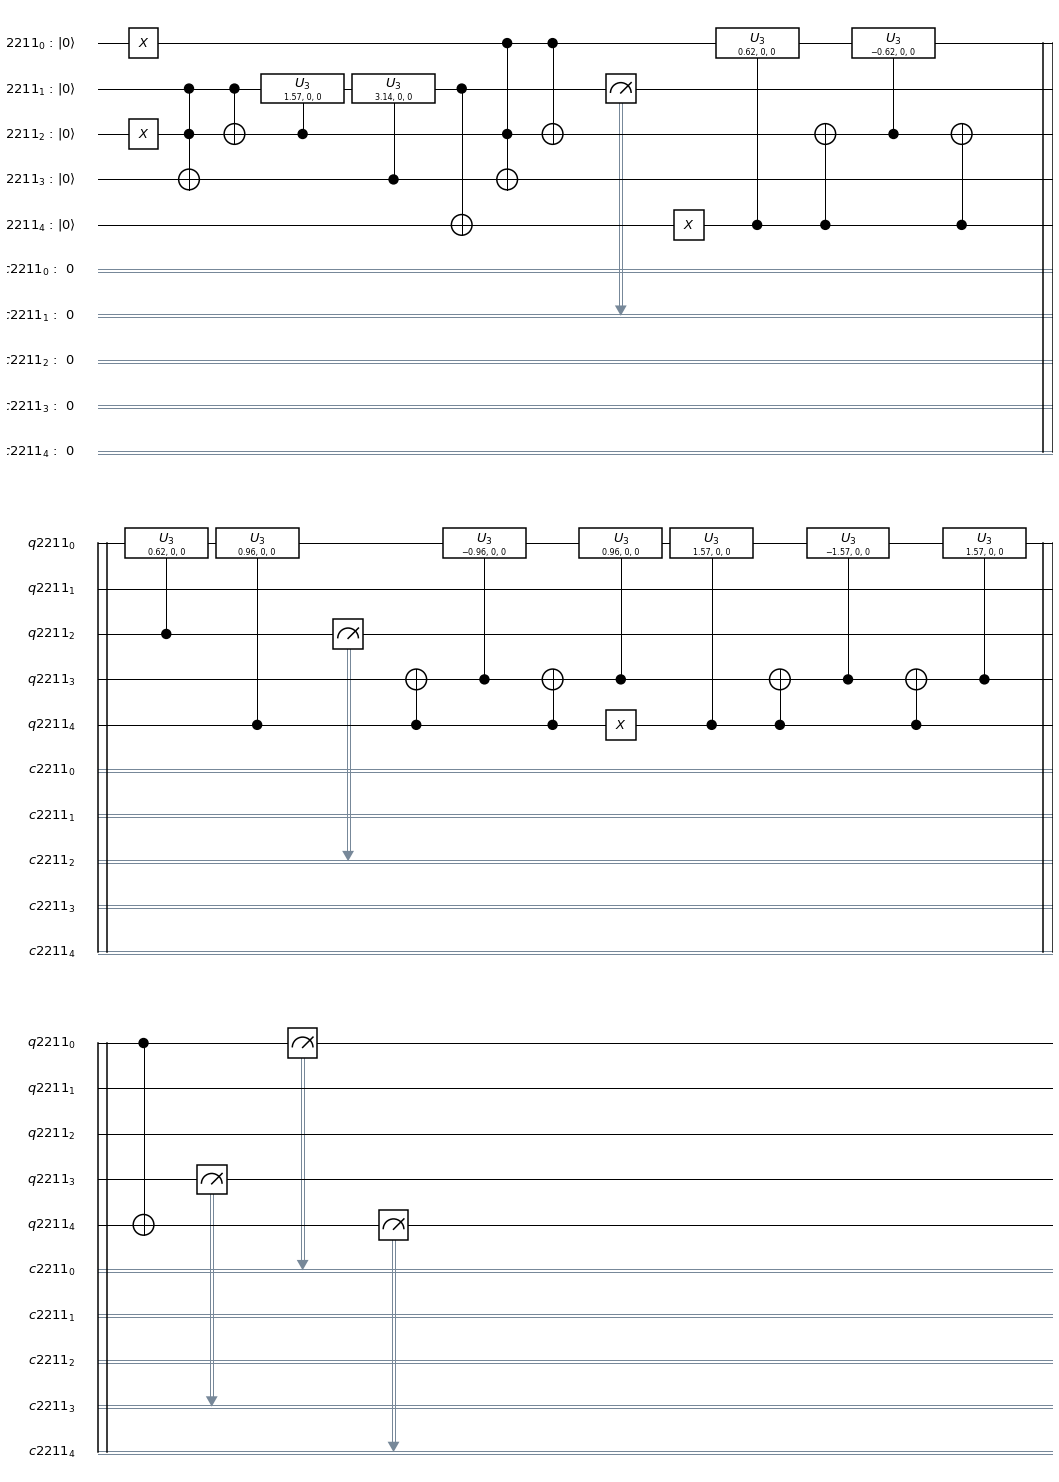

In [27]:
'''
Last Updated: 6/17
Case: n=3 logical qubits

Implementation Details: The top qubit, qubit 6, stores J, representing J=1/2 for initial input 0 and representing 
J=1/2 with 1 and J=3/2 with 0
Qubits 5 and 4 store the m value, with qubit 2 initially storing 0 for 1/2 and 1 for -1/2. At measurement, the two 
qubit state 00 represents 3/2, 01 represents 1/2, 10 is -1/2, and 11 represents -3/2.
Qubit 3 and 2 store the spin in the normal way, and afterward the value of p.
Qubits 1 and 0 are ancillas necessary to run the program
'''


'''
To Improve:
- Abstract the idea of J register and m register so that this is less stupid
    - You can probably do this by creating different registers instead of keeping everything in one
- Encode the p register into some compressed form
    - This is actually not really a priority right now because we're not using this for data compression
- Make the whole thing flexible in the number of logical qubits, allocating physical qubits as necessary
    - This is being done in the below script
'''

# Prepare mixed states that are 0 with probability p
def randomize(qc,regs,p):
    for i in regs:
        if random.random() > p:
            qc.x(i)

# Assumes regs[2] is msb and regs[1]  is lsb          
def add(qc, regs):
    qc.ccx(regs[0],regs[1],regs[2])
    qc.cx(regs[0],regs[1])
    
# Performs doubly controlled y rotation by angle theta
def ccr(qc, ctrl1, ctrl2, target, theta):
    qc.cu3(theta/2,0,0,qr[ctrl1],qr[target])
    qc.cx(qr[ctrl1],qr[ctrl2])
    qc.cu3(-theta/2,0,0,qr[ctrl2],qr[target])
    qc.cx(qr[ctrl1],qr[ctrl2])
    qc.cu3(theta/2,0,0,qr[ctrl2],qr[target])
    
        
shots = 1024
trials = 100
qubits = 5
cbits = 5
pval = 0.7

# Generates cleanData, which stores all the possible outcomes we should get. 
cleanData = {}

for i in range(trials):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(cbits)
    qc = QuantumCircuit(qr,cr)
    
    # Used to create "mixed states"
    randomize(qc,[2,1,0],pval)
    #qc.x(qr[2])
    #qc.x(qr[1])
    #qc.x(qr[0])

    # First Clebsch Gordan transform
    # Logical controlled-NOT from spin s to momentum m
    add(qc, [1,2,3])
    # Logical controlled-Y rotation from J,m to s
    qc.cu3(pi/2, 0,0,qr[2],qr[1])
    qc.cu3(pi, 0,0,qr[3],qr[1])
    # Logical controlled-NOT from spin s to J
    qc.cx(qr[1],qr[4])
    
    
    # Second Clebsch Gordan transform
    add(qc, [0,2,3])
    qc.x(qr[4])
    ccr(qc, 4, 2, 0, 2*np.arccos(sqrt(2/3)))
    ccr(qc, 4, 3, 0, 2*np.arccos(sqrt(1/3)))
    qc.x(qr[4])
    ccr(qc, 4, 3, 0, pi)
    qc.cx(qr[0],qr[4])


    qc.measure(qr,cr)
    qc.draw(output = 'mpl')
    job = execute(qc,simulator, shots=shots)
    result = job.result()
    data = result.get_counts(qc)

    for i in data.keys():
        if i not in cleanData.keys():
            cleanData[i]=0
        cleanData[i] += data[i]/shots


for i in cleanData.keys():
    cleanData[i] = cleanData[i]/trials
    
print(cleanData)

print("Amount of (3/2,3/2):")
print(cleanData['00000'])
print("Amount of (3/2,1/2):")
print(cleanData['00100'])
print("Amount of (3/2,-1/2):")
print(cleanData['01000'])
print("Amount of (3/2,-3/2):")
print(cleanData['01100'])
print("Amount of normal (1/2,1/2):")
print(cleanData['10110'])
print("Amount of normal (1/2,-1/2):")
print(cleanData['11010'])
print("Amount of rotated (1/2,1/2):")
print(cleanData['10101'])
print("Amount of rotated (1/2,-1/2):")
print(cleanData['11001'])

qc.draw(output = 'mpl')

In [28]:
'''
Last Updated: 6/18/19
Case: n logical qubits

Implementation Details:
- Separate registers for separate components
- All zeroes state corresponds to highest possible m value and then counting up is equivalent to subtracting one

'''

# Prepare mixed states that are 0 with probability p
def randomize(qc,regs,p):
    for i in regs:
        if random.random() > p:
            qc.x(i)

# Assumes regs[2] is msb and regs[1]  is lsb          
def add(qc, regs):
    qc.ccx(regs[0],regs[1],regs[2])
    qc.cx(regs[0],regs[1])
    
# Performs doubly controlled y rotation by angle theta
def ccr(qc, ctrl1, ctrl2, target, theta):
    qc.cu3(theta/2,0,0,qr[ctrl1],qr[target])
    qc.cx(qr[ctrl1],qr[ctrl2])
    qc.cu3(-theta/2,0,0,qr[ctrl2],qr[target])
    qc.cx(qr[ctrl1],qr[ctrl2])
    qc.cu3(theta/2,0,0,qr[ctrl2],qr[target])
    
        
shots = 1024
trials = 100
qubits = 5
cbits = 5
pval = 0.7
# Generates cleanData, which stores all the possible outcomes we should get. 
cleanData = {}

for i in range(trials):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(cbits)
    qc = QuantumCircuit(qr,cr)
    
    # Used to create "mixed states"
    randomize(qc,[2,1,0],pval)
    #qc.x(qr[2])
    #qc.x(qr[1])
    #qc.x(qr[0])

    # First Clebsch Gordan transform
    # Logical controlled-NOT from spin s to momentum m
    add(qc, [1,2,3])
    # Logical controlled-Y rotation from J,m to s
    qc.cu3(pi/2, 0,0,qr[2],qr[1])
    qc.cu3(pi, 0,0,qr[3],qr[1])
    # Logical controlled-NOT from spin s to J
    qc.cx(qr[1],qr[4])
    
    
    # Second Clebsch Gordan transform
    add(qc, [0,2,3])
    qc.x(qr[4])
    ccr(qc, 4, 2, 0, 2*np.arccos(sqrt(2/3)))
    ccr(qc, 4, 3, 0, 2*np.arccos(sqrt(1/3)))
    qc.x(qr[4])
    ccr(qc, 4, 3, 0, pi)
    qc.cx(qr[0],qr[4])


    qc.measure(qr,cr)
    qc.draw(output = 'mpl')
    job = execute(qc,simulator, shots=shots)
    result = job.result()
    data = result.get_counts(qc)

    for i in data.keys():
        if i not in cleanData.keys():
            cleanData[i]=0
        cleanData[i] += data[i]/shots


# Normalizes data to get estimate for probability of outcomes
for i in cleanData.keys():
    cleanData[i] = cleanData[i]/trials
    
print(cleanData)


print("Amount of (3/2,3/2):")
print(cleanData['00000'])
print("Amount of (3/2,1/2):")
print(cleanData['00100'])
print("Amount of (3/2,-1/2):")
print(cleanData['01000'])
print("Amount of (3/2,-3/2):")
print(cleanData['01100'])
print("Amount of normal (1/2,1/2):")
print(cleanData['10110'])
print("Amount of normal (1/2,-1/2):")
print(cleanData['11010'])
print("Amount of rotated (1/2,1/2):")
print(cleanData['10101'])
print("Amoutn of rotated (1/2,-1/2):")
print(cleanData['11001'])

qc.draw(output = 'mpl')

{'01000': 0.0619921875, '11001': 0.051826171875, '11010': 0.076181640625, '00000': 0.33, '00100': 0.16048828125, '10101': 0.144921875, '10110': 0.17458984375}
Amount of (3/2,3/2):
0.33
Amount of (3/2,1/2):
0.16048828125
Amount of (3/2,-1/2):
0.0619921875
Amount of (3/2,-3/2):


KeyError: '01100'